In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random
import matplotlib.pyplot as plt

from sklearn import metrics
from scipy import stats
from collections import Counter
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator
torch.cuda.empty_cache()
import training_utils.partitioning_utils as pat_utils
from tqdm import trange

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


## ESM C

In [2]:
Df_train = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_train.csv",index_col=0).reset_index(drop=True)
Df_test = pd.read_csv("/work3/s232958/data/PPint_DB/PPint_test.csv",index_col=0).reset_index(drop=True)

class CLIP_PPint_dataclass(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_path  = path

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = parts[0]+"_"+parts[2]
            bnd_id = parts[-3]+"_"+parts[-1]

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy")).squeeze(0)     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy")).squeeze(0)     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

emb_path = "/work3/s232958/data/PPint_DB/embeddings_esmC"

testing_Dataset = CLIP_PPint_dataclass(
    Df_test,
    path=emb_path,
    embedding_dim=1152
)

Df_test_non_dimer = Df_test[Df_test.dimer == False]

non_dimers_Dataset = CLIP_PPint_dataclass(
    Df_test_non_dimer,
    path=emb_path,
    embedding_dim=1152
)

#Loading ESM2 embeddings and contacts: 100%|█████████████████████████████████████████| 122/122 [00:00<00:00, 153.25it/s]


In [3]:
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv")[["A_seq", "B_seq", "target_id_mod", "target_binder_ID", "binder"]].rename(columns = {
    "A_seq" : "seq_binder",
    "B_seq" : "seq_target",
    "target_binder_ID" : "binder_id",
    "target_id_mod" : "target_id",
    "binder" : "binder_label"
})
interaction_df["seq_target_len"] = [len(seq) for seq in interaction_df["seq_target"].tolist()]
interaction_df["seq_binder_len"] = [len(seq) for seq in interaction_df["seq_binder"].tolist()]

# Targets df
target_df = interaction_df[["target_id","seq_target"]].rename(columns={"seq_target":"sequence", "target_id" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["binder_id","seq_binder"]].rename(columns={"seq_binder":"sequence", "binder_id" : "ID"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# target_df

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id"], interaction_df["binder_id"]), start=1))
interaction_df_shuffled = interaction_df.sample(frac=1, random_state=0).reset_index(drop=True)
interaction_df_shuffled

,seq_binder,seq_target,target_id,binder_id,binder_label,seq_target_len,seq_binder_len
0,DIVEEAHKLLSRAMSEAMENDDPDKLRRANELYFKLEEALKNNDPK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_124,True,101,62
1,SEELVEKVVEEILNSDLSNDQKILETHDRLMELHDQGKISKEEYYK...,LEEKKVCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYV...,EGFR_2,EGFR_2_149,False,621,58
2,TINRVFHLHIQGDTEEARKAHEELVEEVRRWAEELAKRLNLTVRVT...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_339,False,101,65
3,DDLRKVERIASELAFFAAEQNDTKVAFTALELIHQLIRAIFHNDEE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1234,False,101,64
4,DEEVEELEELLEKAEDPRERAKLLRELAKLIRRDPRLRELATEVVA...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_48,False,165,65
...,...,...,...,...,...,...,...
3527,SEDELRELVKEIRKVAEKQGDKELRTLWIEAYDLLASLWYGAADEL...,TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFK...,SARS_CoV2_RBD,SARS_CoV2_RBD_25,False,195,63
3528,TEEEILKMLVELTAHMAGVPDVKVEIHNGTLRVTVNGDTREARSVL...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2027,False,101,65
3529,VEELKEARKLVEEVLRKKGDQIAEIWKDILEELEQRYQEGKLDPEE...,DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKC...,IL7Ra,IL7Ra_90,False,193,63
3530,DAEEEIREIVEKLNDPLLREILRLLELAKEKGDPRLEAELYLAFEK...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1605,False,101,65


In [4]:
class CLIP_Meta_class(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1152,
        embedding_pad_value=-5000.0
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy")).squeeze(0)     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy")).squeeze(0)      # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        return binder_emb, target_emb, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_binders"
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esmC_targets"

validation_Dataset = CLIP_Meta_class(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_df_shuffled,
    paths=[bemb_path, temb_path],
    embedding_dim=1152
)

#Loading ESM2 embeddings: 100%|████████████████████████████████████████████████████| 3532/3532 [00:21<00:00, 163.99it/s]


In [5]:
accessions_Meta = list(interaction_df_shuffled.binder_id)
emb_b, emb_t, labels = validation_Dataset._get_by_name(accessions_Meta[:5])
labels

tensor([1, 0, 0, 0, 0])

### Loading Pre-trained Model

In [6]:
embedding_dimension = 1152

In [7]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=embedding_dimension, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_trans  
            prot_emb = prot_emb + prot_trans

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding), dim=-1)
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding), dim=-1)
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        positive_logits = self.forward(embedding_pep, embedding_prot)
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], 
                          embedding_prot[cols,:,:], 
                          int_prob=0.0)

        # loss of predicting partner using peptide
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self(embedding_pep, embedding_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
    
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_binder, embedding_target, labels = batch
        embedding_binder = embedding_binder.to(device)
        embedding_target = embedding_target.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_binder, embedding_target)
            logits = logits.float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        
        positive_logits = self(embedding_pep, embedding_prot)
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [9]:
os.listdir("/work3/s232958/data/trained/original_architecture/4333f167-963b-421b-aabe-a9fd5889311d/4333f167-963b-421b-aabe-a9fd5889311d_checkpoint_6")

['4333f167-963b-421b-aabe-a9fd5889311d_checkpoint_epoch_6.pth']

In [10]:
model = MiniCLIP_w_transformer_crossattn(embed_dimension=1152, num_recycles=2).to("cuda")
path = "/work3/s232958/data/trained/original_architecture/4333f167-963b-421b-aabe-a9fd5889311d/4333f167-963b-421b-aabe-a9fd5889311d_checkpoint_6/4333f167-963b-421b-aabe-a9fd5889311d_checkpoint_epoch_6.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

In [11]:
def collate_varlen(batch):
    b_emb = torch.stack([x[0] for x in batch], dim=0)
    t_emb = torch.stack([x[1] for x in batch], dim=0)
    lbls = torch.tensor([x[2].float() for x in batch])
    return b_emb, t_emb, lbls

test_dataloader = DataLoader(testing_Dataset, batch_size=10, collate_fn=collate_varlen)
non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10, collate_fn=collate_varlen)
validation_dataloader = DataLoader(validation_Dataset, batch_size=10, shuffle=False, drop_last = False, collate_fn=collate_varlen)

In [12]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(test_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        positive_logits = model(embedding_pep, embedding_prot)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device="cuda")
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device="cuda")
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

#Iterating through batched data: 50it [00:18,  2.64it/s]                                                                

Positives: (494,)
Negatives: (2211,)


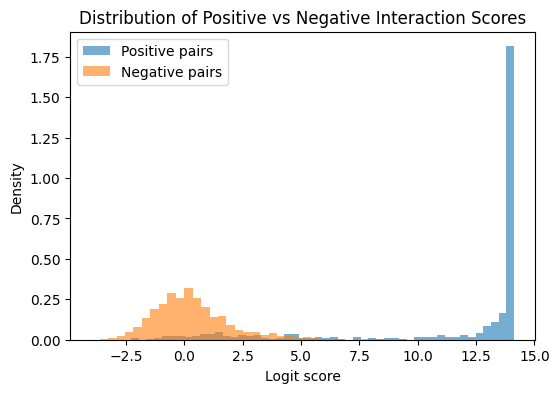

In [13]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers

In [14]:
interaction_scores = []

for batch in tqdm(non_dimers_dataloader, total=round(len(Df_test_non_dimer)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

# Convert list of tensors to single 1D tensors
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
# interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

#Iterating through batched data: 13it [00:01, 11.10it/s]                                                                


#### meta-analysis

In [ ]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder_label == False:
        neg_logits.append(logit)
    elif row.binder_label == True:
        pos_logits.append(logit)

plt.figure(figsize=(5, 4))

plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

#Iterating through batched data:  82%|███████████████████████████████████████▍        | 290/353 [00:26<00:06,  9.09it/s]

## ESM 2

In [ ]:
class CLIP_PPint_class(Dataset):
    def __init__(
        self,
        dframe,
        path,
        embedding_dim=1280,
        embedding_pad_value=-5000.0,
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)

        # lengths
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_path  = path

        # index & storage
        self.dframe.set_index("target_binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings and contacts"):
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = parts[0]+"_"+parts[2]
            bnd_id = parts[-3]+"_"+parts[-1]

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_path, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_path, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        label = torch.tensor(1, dtype=torch.float32)  # single scalar labe
        return binder_emb, target_emb, label

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

emb_path = "/work3/s232958/data/PPint_DB/embeddings_esm2"

training_Dataset = CLIP_PPint_class(
    Df_train,
    path=emb_path,
    embedding_dim=1280
)

testing_Dataset = CLIP_PPint_class(
    Df_test,
    path=emb_path,
    embedding_dim=1280
)

In [ ]:
class CLIP_Meta_class(Dataset):
    def __init__(
        self,
        dframe,
        paths,
        embedding_dim=1280,
        embedding_pad_value=-5000.0
    ):
        super().__init__()
        self.dframe = dframe.copy()
        self.embedding_dim = int(embedding_dim)
        self.emb_pad = float(embedding_pad_value)
        self.max_blen = self.dframe["seq_binder_len"].max()
        self.max_tlen = self.dframe["seq_target_len"].max()

        # paths
        self.encoding_bpath, self.encoding_tpath = paths

        # index & storage
        self.dframe.set_index("binder_id", inplace=True)
        self.accessions = self.dframe.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        self.samples = []

        for accession in tqdm(self.accessions, total=len(self.accessions), desc="#Loading ESM2 embeddings"):
            lbl = torch.tensor(int(self.dframe.loc[accession, "binder_label"]))
            parts = accession.split("_") # e.g. accession 7S8T_5_F_7S8T_5_G
            tgt_id = "_".join(parts[:-1])
            bnd_id = accession

            ### --- embeddings (pad to fixed lengths) --- ###
            
            # laod embeddings
            t_emb = np.load(os.path.join(self.encoding_tpath, f"{tgt_id}.npy"))     # [Lt, D]
            b_emb = np.load(os.path.join(self.encoding_bpath, f"{bnd_id}.npy"))     # [Lb, D]

            # quich check whether embedding dimmension is as it suppose to be
            if t_emb.shape[1] != self.embedding_dim or b_emb.shape[1] != self.embedding_dim:
                raise ValueError("Embedding dim mismatch with 'embedding_dim'.")

            # add -5000 to all the padded target rows
            if t_emb.shape[0] < self.max_tlen:
                t_emb = np.concatenate([t_emb, np.full((self.max_tlen - t_emb.shape[0], t_emb.shape[1]), self.emb_pad, dtype=t_emb.dtype)], axis=0)
            else:
                t_emb = t_emb[: self.max_tlen] # no padding was used

            # add -5000 to all the padded binder rows
            if b_emb.shape[0] < self.max_blen:
                b_emb = np.concatenate([b_emb, np.full((self.max_blen - b_emb.shape[0], b_emb.shape[1]), self.emb_pad, dtype=b_emb.dtype)], axis=0)
            else:
                b_emb = b_emb[: self.max_blen] # no padding was used

            self.samples.append((b_emb, t_emb, lbl))

    # ---- Dataset API ----
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        b_arr, t_arr, lbls = self.samples[idx]
        binder_emb, target_emb = torch.from_numpy(b_arr).float(), torch.from_numpy(t_arr).float()
        return binder_emb, target_emb, lbls

    def _get_by_name(self, name):
        # Single item -> return exactly what __getitem__ returns
        if isinstance(name, str):
            return self.__getitem__(self.name_to_row[name])
        
        # Multiple items -> fetch all
        out = [self.__getitem__(self.name_to_row[n]) for n in list(name)]
        b_list, t_list, lbl_list = zip(*out)
    
        # Stack embeddings
        b  = torch.stack([torch.as_tensor(x) for x in b_list],  dim=0)  # [B, ...]
        t  = torch.stack([torch.as_tensor(x) for x in t_list],  dim=0)  # [B, ...]
    
        # Stack labels
        labels = torch.stack(lbl_list)  # [B]
    
        return b, t, labels

bemb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_binders"
temb_path = "/work3/s232958/data/meta_analysis/embeddings_esm2_targets"

validation_Dataset = CLIP_Meta_class(
    # interaction_df_shuffled[:len(Df_test)],
    interaction_df_shuffled,
    paths=[bemb_path, temb_path],
    embedding_dim=1280
)

### Loading Pre-trained Model

In [ ]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    """
    Purpose: return vector indicating which rows are not padded (don't have values = -5000)
    """
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1280] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

def get_sinusoid_encoding(num_tokens, token_len):
    """
    Purpose: positional encoding having the same dimensions as token matrix
    Standard Vaswani sinusoidal positional encoding for a sequence of length L=num_tokens and dim D=token_len.
    Returns: [L, D] tensor (no batch dim).
    """
    device = torch.device("cpu")
    L, D = num_tokens, token_len
    pos = torch.arange(L, dtype=torch.float32, device=device).unsqueeze(1)      # [L,1]
    i   = torch.arange(D, dtype=torch.float32, device=device).unsqueeze(0)      # [1,D]
    div = torch.pow(10000.0, (2 * torch.floor(i/2)) / D)                        # [1,D]
    angles = pos / div                                                          # [L,D]
    pe = torch.zeros(L, D, dtype=torch.float32, device=device)
    pe[:, 0::2] = torch.sin(angles[:, 0::2])
    pe[:, 1::2] = torch.cos(angles[:, 1::2])
    return pe

def pad_tokens_to_L(tokens: torch.Tensor, L_target: int):
    if tokens.dim() == 3:
        B, Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:, :L_target, :]
        pad = tokens.new_zeros(B, L_target - Ls, D)
        return torch.cat([tokens, pad], dim=1)
    elif tokens.dim() == 2:
        Ls, D = tokens.shape
        if Ls >= L_target:
            return tokens[:L_target]
        pad = tokens.new_zeros(L_target - Ls, D)
        return torch.cat([tokens, pad], dim=0)
    else:
        raise ValueError(f"Unexpected tokens.dim()={tokens.dim()} (wanted 2 or 3)")

In [ ]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=embedding_dimension, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_trans  
            prot_emb = prot_emb + prot_trans

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding), dim=-1)
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding), dim=-1)
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        positive_logits = self.forward(embedding_pep, embedding_prot)
        
        # Negative indexes
        rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)         
        
        negative_logits = self(embedding_pep[rows,:,:], 
                          embedding_prot[cols,:,:], 
                          int_prob=0.0)

        # loss of predicting partner using peptide
        positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
 
        # loss of predicting peptide using partner
        negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))
        
        loss = (positive_loss + negative_loss) / 2
 
        # del partner_prediction_loss, peptide_prediction_loss, embedding_pep, embedding_prot
        torch.cuda.empty_cache()
        return loss

    def validation_step_PPint(self, batch, device):
        # Predict on random batches of training batch size
        embedding_pep, embedding_prot, labels = batch
        embedding_pep, embedding_prot = embedding_pep.to(device), embedding_prot.to(device)
        
        with torch.no_grad():

            positive_logits = self(embedding_pep, embedding_prot)
            
            # loss of predicting partner using peptide
            positive_loss = F.binary_cross_entropy_with_logits(positive_logits, torch.ones_like(positive_logits).to(device))
            
            # Negaive indexes
            rows, cols = torch.triu_indices(embedding_prot.size(0), embedding_prot.size(0), offset=1)
            
            negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
    
            negative_loss =  F.binary_cross_entropy_with_logits(negative_logits, torch.zeros_like(negative_logits).to(device))

            loss = (positive_loss + negative_loss) / 2
           
            logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
            logit_matrix[rows, cols] = negative_logits
            logit_matrix[cols, rows] = negative_logits
            
            # Fill diagonal with positive scores
            diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
            logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()

            labels = torch.arange(embedding_prot.size(0)).to(self.device)
            peptide_predictions = logit_matrix.argmax(dim=0)
            peptide_ranks = logit_matrix.argsort(dim=0).diag() + 1
            peptide_mrr = (peptide_ranks).float().pow(-1).mean()
            
            # partner_accuracy = partner_predictions.eq(labels).float().mean()
            peptide_accuracy = peptide_predictions.eq(labels).float().mean()
    
            k = 3
            peptide_topk_accuracy = torch.any((logit_matrix.topk(k, dim=0).indices - labels.reshape(1, -1)) == 0, dim=0).sum() / logit_matrix.shape[0]
    
            del logit_matrix,positive_logits,negative_logits,embedding_pep,embedding_prot

            return loss, peptide_accuracy, peptide_topk_accuracy
    
    def validation_step_MetaDataset(self, batch, device):
        embedding_binder, embedding_target, labels = batch
        embedding_binder = embedding_binder.to(device)
        embedding_target = embedding_target.to(device)
        labels = labels.to(device).float()
    
        with torch.no_grad():
            logits = self.forward(embedding_binder, embedding_target)
            logits = logits.float()
            loss = F.binary_cross_entropy_with_logits(logits.view(-1), labels.view(-1))
            return logits, loss

    def calculate_logit_matrix(self,embedding_pep,embedding_prot):
        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        
        positive_logits = self(embedding_pep, embedding_prot)
        negative_logits = self(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device=self.device)
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device=self.device)
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        return logit_matrix

In [ ]:
testing_dataloader = DataLoader(testing_Dataset, batch_size=10, shuffle=False)
validation_dataloader = DataLoader(validation_Dataset, batch_size=10, shuffle=False)

In [ ]:
os.listdir("/work3/s232958/data/trained/original_architecture/63a90678-26de-48fc-844f-737d34fa60a3")

In [ ]:
model = MiniCLIP_w_transformer_crossattn(embed_dimension=1280, num_recycles=2).to("cuda")
path = "/work3/s232958/data/trained/original_architecture/63a90678-26de-48fc-844f-737d34fa60a3/63a90678-26de-48fc-844f-737d34fa60a3_checkpoint_6/63a90678-26de-48fc-844f-737d34fa60a3_checkpoint_epoch_6.pth"
checkpoint = torch.load(path, weights_only=False, map_location=torch.device('cpu'))
# print(list(checkpoint["model_state_dict"]))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()  

In [ ]:
interaction_scores_pos = []
interaction_scores_neg = []    

for batch in tqdm(testing_dataloader, total=round(len(Df_test)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():

        rows, cols = torch.triu_indices(embedding_pep.size(0), embedding_pep.size(0), offset=1)
        positive_logits = model(embedding_pep, embedding_prot)
        negative_logits = model(embedding_pep[rows,:,:], embedding_prot[cols,:,:], int_prob=0.0)
        
        logit_matrix = torch.zeros((embedding_pep.size(0),embedding_pep.size(0)),device="cuda")
        logit_matrix[rows, cols] = negative_logits
        logit_matrix[cols, rows] = negative_logits
        
        diag_indices = torch.arange(embedding_pep.size(0), device="cuda")
        logit_matrix[diag_indices, diag_indices] = positive_logits.squeeze()
        
        # print(logit_matrix)
        interaction_scores_pos.append(positive_logits)
        interaction_scores_neg.append(negative_logits)

# Convert list of tensors to single 1D tensors
pos_logits = torch.cat(interaction_scores_pos).detach().cpu().numpy()
neg_logits = torch.cat(interaction_scores_neg).detach().cpu().numpy()
print("Positives:", pos_logits.shape)
print("Negatives:", neg_logits.shape)

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)
plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")
plt.legend()
plt.show()

#### non-dimers

In [ ]:
Df_test_non_dimer = Df_test[Df_test.dimer == False]

non_dimers_Dataset = CLIP_PPint_class(
    Df_test_non_dimer,
    path=emb_path,
    embedding_dim=1280)

non_dimers_dataloader = DataLoader(non_dimers_Dataset, batch_size=10, shuffle = False)

interaction_scores = []
for batch in tqdm(non_dimers_dataloader, total=round(len(Df_test_non_dimer)/10), desc="#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

# Convert list of tensors to single 1D tensors
predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])

#### meta-analysis

In [ ]:
# Loading batches
interaction_scores = []

for batch in tqdm(validation_dataloader, total = round(len(interaction_df_shuffled)/10),  desc= "#Iterating through batched data"):
    b_emb, t_emb, lbls = batch
    embedding_pep = b_emb.to("cuda")
    embedding_prot = t_emb.to("cuda")

    with torch.no_grad():
        positive_logits = model(embedding_pep, embedding_prot)
        interaction_scores.append(positive_logits.unsqueeze(0))

predicted_interaction_scores = np.concatenate([batch_score.cpu().detach().numpy().reshape(-1,) for batch_score in interaction_scores])
interaction_probabilities = np.concatenate([torch.sigmoid(batch_score[0]).cpu().numpy() for batch_score in interaction_scores])

pos_logits, neg_logits = [], []
for i, row in interaction_df_shuffled.iterrows():
    logit = predicted_interaction_scores[i]
    if row.binder_label == False:
        neg_logits.append(logit)
    elif row.binder_label == True:
        pos_logits.append(logit)

plt.figure(figsize=(5, 4))

plt.hist(neg_logits, bins=50, alpha=0.6, label="Negative pairs", density=True)
plt.hist(pos_logits, bins=50, alpha=0.6, label="Positive pairs", density=True)

plt.xlabel("Logit score")
plt.ylabel("Density")
plt.title("Distribution of Positive vs Negative Interaction Scores")

# --- Simple grid behind ---
plt.grid(True, linestyle="--", alpha=0.5)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
interaction_df_shuffled["inter_prob"] = interaction_probabilities
interaction_df_shuffled["pred_binder"] = interaction_df_shuffled["inter_prob"] >= 0.5
interaction_df_shuffled["intr_scores"] = predicted_interaction_scores

pred_labels = interaction_probabilities >= 0.5
true_labels = np.array(interaction_df_shuffled["binder_label"])

true_positives = ((pred_labels == 1) & (true_labels == 1)).sum().item()
true_negatives = ((pred_labels == 0) & (true_labels == 0)).sum().item()
false_positives = ((pred_labels == 1) & (true_labels == 0)).sum().item()
false_negatives = ((pred_labels == 0) & (true_labels == 1)).sum().item()

predicted_positives = true_positives + false_positives
all_real_positives = true_positives + false_negatives

print(classification_report(true_labels, pred_labels, digits = 4))

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(true_labels, pred_labels))
disp.plot(ax=axes[0])
axes[0].set_title("Confusion Matrix")

TPR = true_positives / (true_positives + true_negatives) # how good the model is at predicting the positive class when the actual outcome is positive.
# sensitivity = true_positives / (true_positives + false_negatives) # the same as TPR
FPR = false_positives / (false_positives + true_negatives) # how often a positive class is predicted when the actual outcome is negative.
# specificity = true_negatives / (true_negatives + false_positives) # FPR = 1 - specificity

fpr, tpr, thresholds = roc_curve(true_labels, interaction_probabilities)
auc = roc_auc_score(true_labels, interaction_probabilities)
print('AUC: %.3f' % auc)

axes[1].plot(fpr, tpr, linewidth=2)
axes[1].plot([0, 1], [0, 1], linestyle="--", linewidth=1)  # diagonal reference
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].set_title('ROC Curve')

# show the plot
plt.tight_layout()
plt.show()